<a id='head'></a>
## Mouse Pancreas scRNA-seq Analysis

by Wesley Lewis and Vimig Socrates

This analysis primarily makes use of scVelo and scHPF:
    
    -scVelo:
    Bergen, V., Lange, M., Peidli, S. et al. Generalizing RNA velocity to transient cell states through dynamical modeling. Nat Biotechnol 38, 1408–1414 (2020). https://doi.org/10.1038/s41587-020-0591-3
    
    -scHPF:
    De novo gene signature identification from single‐cell RNA‐seq with hierarchical Poisson factorization
    Levitin, HM., Mol Syst Biol (2019)15:e8557. https://doi.org/10.15252/msb.20188557

Data is from the scVelo Dynamic Velocity tutorial:

    -scVelo Tutorial: https://scvelo.readthedocs.io/DynamicalModeling.html
    

scRNA-seq originally sourced from:

    Comprehensive single cell mRNA profiling reveals a detailed roadmap for pancreatic endocrinogenesis
    Aimée Bastidas-Ponce, Sophie Tritschler, Leander Dony, Katharina Scheibner, Marta Tarquis-Medina, Ciro Salinno, Silvia Schirge, Ingo Burtscher, Anika Böttcher, Fabian J. Theis, Heiko Lickert, Mostafa Bakhti
    Development 2019 146: dev173849 doi: 10.1242/dev.173849 Published 17 June 2019



### Navigation Links:

[Head](#head)

[Downloading and Pre-processing Data](#data)
    
[scHPF commands](#schpfcom)

[scHPF analysis](#schpfanal)

[RNA Velocity analysis (scVelo)](#another_cell)

[Summary](#another_cell)

In [119]:
import numba
import sklearn
import pandas as pd
import loompy
import numpy as np
import scanpy as sc
import scprep
import phate
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.2 (python 3.6.9) on 2020-12-18 19:07.


In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

<a id='data'></a>
### Downloading and Pre-processing Data

In [4]:
adata = scv.datasets.pancreas()

In [5]:
adata2 = adata.copy()

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


<a id='schpfcom'></a>
## Now run scHPF on the count matrix

1: Prepare and save un-normalized matrix

2: Save variables for scHPF commands - note that these files are enclosed within scHPF package install folder

3: Run prep command

In [7]:
#create dense matrix from sparse
densemat = adata2.X.todense().T.astype(int)
i = densemat.shape[0] ; j = densemat.shape[1]
print(densemat.shape)
print(i, j)
#create new numpy object with additional dimensions for scHPF vars
hpfmat = np.empty(shape=(i,j+2),dtype=object)
print(hpfmat.shape)

(27998, 3696)
27998 3696
(27998, 3698)


In [8]:
#get list of genes/vars from the original matrix
adata2.var.shape #this is the number of genes. should match the first dim of both matrixes
adata2.var.index
#fill in the new matrix
hpfmat[:,0]=adata2.var.index #since these are already ensmble IDs the two cols are equivalent
hpfmat[:,1]=adata2.var.index
hpfmat[:,2:]=densemat
hpfmat

array([['Xkr4', 'Xkr4', 0, ..., 0, 0, 0],
       ['Gm37381', 'Gm37381', 0, ..., 0, 0, 0],
       ['Rp1', 'Rp1', 0, ..., 0, 0, 0],
       ...,
       ['Gm29504', 'Gm29504', 0, ..., 0, 0, 0],
       ['Gm20837', 'Gm20837', 0, ..., 0, 0, 0],
       ['Erdr1', 'Erdr1', 0, ..., 0, 0, 0]], dtype=object)

In [9]:
#save hpfmat
np.savetxt("/data/tapedir/notebooks/HPF_Project/hpfmat.csv", hpfmat, fmt="%s", delimiter=" ")

In [10]:
whitelist = "/data/tapedir/notebooks/HPF_Project/scHPF/resources/gencode.vM19.annotation.gene_l1l2.pc_TRC_IGC.stripped.txt"
countmatrix ="/data/tapedir/notebooks/HPF_Project/hpfmat.csv"
outdir = "/data/tapedir/notebooks/HPF_Project/hpf-out"

In [14]:
#running scHPF
!scHPF prep -i {countmatrix} -o {outdir} -m 10 -w {whitelist} --filter-by-gene-name

Loading data.....
	loaded 10000 genes for 3696 cells
	loaded 20000 genes for 3696 cells
.....found 3696 cells and 27998 genes
Generating masks for filtering.....
Filtering data.....
Writing filtered data to file.....
Writing commandline arguments to file.....


In [15]:
prefix = "Pancreas"
prepfile = "/data/tapedir/notebooks/HPF_Project/hpf-out/filtered.mtx"

In [16]:
!scHPF train -i {prepfile} -o {outdir} -p {prefix} -k 7 -t 5

Loading data.....
.....found 3696 cells and 12170 genes in /data/tapedir/notebooks/HPF_Project/hpf-out/filtered.mtx
Running trials.....
[Iter.    0]  loss:17.673517  pct:100.000000000
[Iter.   10]  loss:2.278410  pct:-87.108337068
[Iter.   20]  loss:2.169655  pct:-4.773284586
[Iter.   30]  loss:2.084631  pct:-3.918772343
[Iter.   40]  loss:2.067968  pct:-0.799327803
[Iter.   50]  loss:2.058129  pct:-0.475792285
[Iter.   60]  loss:2.054124  pct:-0.194620569
[Iter.   70]  loss:2.052274  pct:-0.090047304
[Iter.   80]  loss:2.051229  pct:-0.050895589
[Iter.   90]  loss:2.050585  pct:-0.031433867
[Iter.  100]  loss:2.050127  pct:-0.022330123
[Iter.  110]  loss:2.049741  pct:-0.018809230
[Iter.  120]  loss:2.049311  pct:-0.020978323
[Iter.  130]  loss:2.048855  pct:-0.022245342
[Iter.  140]  loss:2.048407  pct:-0.021890244
[Iter.  150]  loss:2.047862  pct:-0.026582177
[Iter.  160]  loss:2.046895  pct:-0.047217174
[Iter.  170]  loss:2.046167  pct:-0.035563737
[Iter.  180]  loss:2.045527  pct:

[Iter.  160]  loss:2.037671  pct:-0.005824464
[Iter.  170]  loss:2.037571  pct:-0.004889933
[Iter.  180]  loss:2.037457  pct:-0.005617623
[Iter.  190]  loss:2.037370  pct:-0.004257158
[Iter.  200]  loss:2.037330  pct:-0.001971232
[Iter.  210]  loss:2.037289  pct:-0.001988183
[Iter.  220]  loss:2.037272  pct:-0.000846070
[Iter.  230]  loss:2.037253  pct:-0.000963764
converged
Trial 4 loss: 2.037253
Best loss: 2.031543 (trial 3)
Saving best model (7 factors).....
Writing commandline arguments to file.....
/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.train_commandline_args.json




Output a gene x cell score matrix and a ranked gene list for further analyses:

In [18]:
model = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.scHPF_K7_b0_5trials.joblib"

!scHPF score -m {model} -o {outdir} -p {prefix}

Loading model.....
Calculating scores.....
Saving scores.....
Calculating mean cellscore fractions.....
Calculating maximum pairwise overlaps.....
Writing commandline arguments to file.....


Output a ranked list of gene names with scores for each factor:

In [19]:
#To also generate a tab-delimited file of gene names, ranked by gene-score for each factor:
genesfile = "/data/tapedir/notebooks/HPF_Project/hpf-out/genes.txt"
!scHPF score -m {model} -o {outdir} -p {prefix} -g {genesfile}

Loading model.....
Calculating scores.....
Saving scores.....
Calculating mean cellscore fractions.....
Calculating maximum pairwise overlaps.....
Ranking genes.....
.....using 1'th column of genefile as gene label
Saving ranked genes.....
Writing commandline arguments to file.....


<a id='schpfanal'></a>
### Analyze scHPF and Pancreas Data

1. Overlaying HPF cell scores onto data embeddings
2. Calculating RNA Velocity
3. Comparing with real programming identified by RNA velocity
    - Idea is, if real biological programs are being pulled out of the static timepoint scRNA-seq data with HPF, they should be somewhat consistent with the additional spatial components of RNA velocity

In [21]:
#scHPF output paths
gene_scores = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.gene_score.txt"
cell_scores = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.cell_score.txt"
ranked_genes = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.ranked_genes.txt"

In [111]:
gscores = np.loadtxt(gene_scores)
cscores = np.loadtxt(cell_scores) 
rgenes = np.loadtxt(ranked_genes,dtype=str)
genelist = np.loadtxt(genesfile,dtype=str)

print(gscores.shape) #genes by factors
print(cscores.shape) #cells by factors
print(rgenes.shape) #genes by factors (as string of gene names)
print(genelist.shape) #genes by factors (as string of gene names)

(12170, 7)
(3696, 7)
(12170, 7)
(12170, 2)


### Give each cell a score for each factor in each adata object

- Edit both adata and adata2 .obs matrixes

In [34]:
newcols = ["f1","f2","f3","f4","f5","f6","f7"]
c=0
for i in newcols:
    adata.obs[i]=cscores[:,c]
    adata2.obs[i]=cscores[:,c]
    c=c+1

In [41]:
adata.obs.iloc[:3,-7:]

f1        f2        f3        f4        f5        f6  \
index                                                                          
AAACCTGAGAGGGATA  0.000250  1.950546  0.000342  0.775351  0.000205  0.103975   
AAACCTGAGCCTTGAT  0.674096  0.007060  0.000263  0.005001  1.489191  0.011215   
AAACCTGAGGCAATTA  0.030326  1.875743  0.411268  0.167641  0.031902  0.000326   

                        f7  
index                       
AAACCTGAGAGGGATA  0.267835  
AAACCTGAGCCTTGAT  0.912008  
AAACCTGAGGCAATTA  0.580840

In [42]:
adata2.obs.iloc[:3,-7:]

f1        f2        f3        f4        f5        f6  \
index                                                                          
AAACCTGAGAGGGATA  0.000250  1.950546  0.000342  0.775351  0.000205  0.103975   
AAACCTGAGCCTTGAT  0.674096  0.007060  0.000263  0.005001  1.489191  0.011215   
AAACCTGAGGCAATTA  0.030326  1.875743  0.411268  0.167641  0.031902  0.000326   

                        f7  
index                       
AAACCTGAGAGGGATA  0.267835  
AAACCTGAGCCTTGAT  0.912008  
AAACCTGAGGCAATTA  0.580840

We can use the adata.obs['clusters'] specific cell type/cluster identity labels to overlay cluster identity on multiple types of embeddings.

Let's use PCA, UMAP, and PHATE.

    -PCA
    Use existing PCA's (from the loaded matrix)
    -UMAP
    Use existing UMAP coords (from the loaded matrix)
    -PHATE
    Calculate PHATE

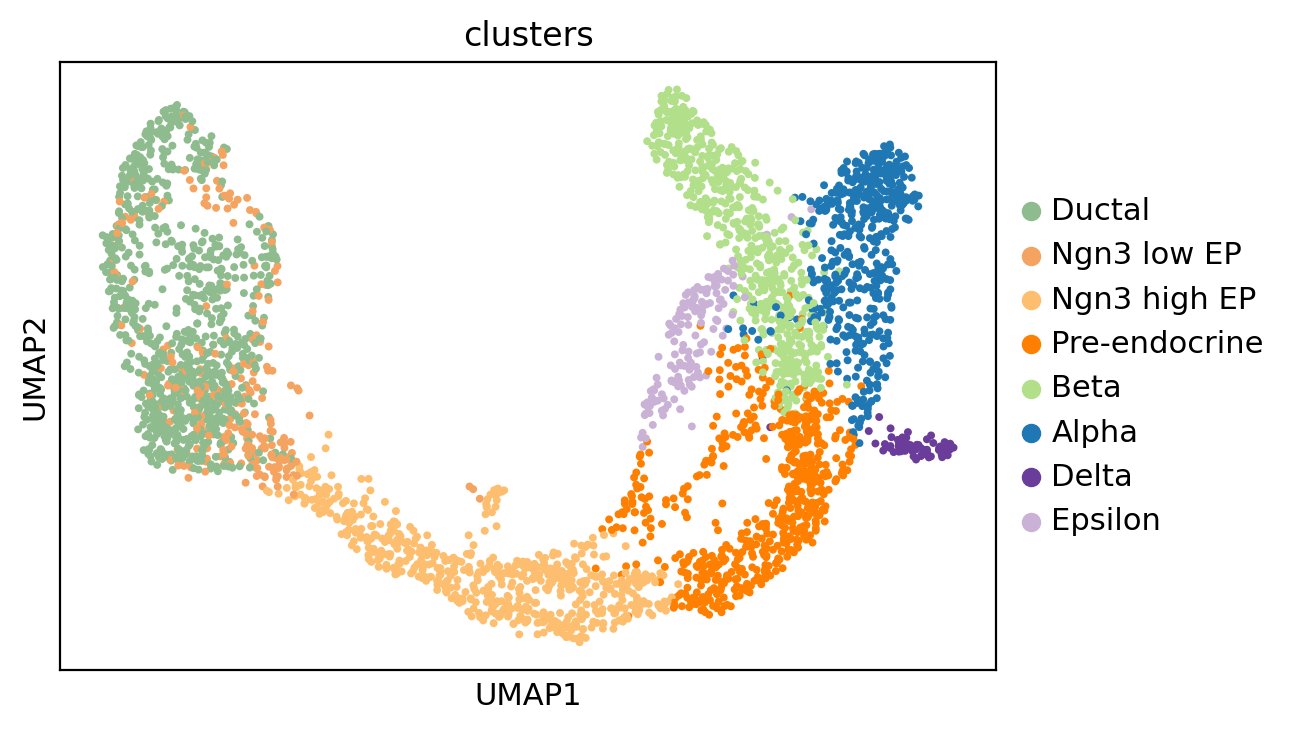

In [51]:
sc.pl.umap(adata,color='clusters')

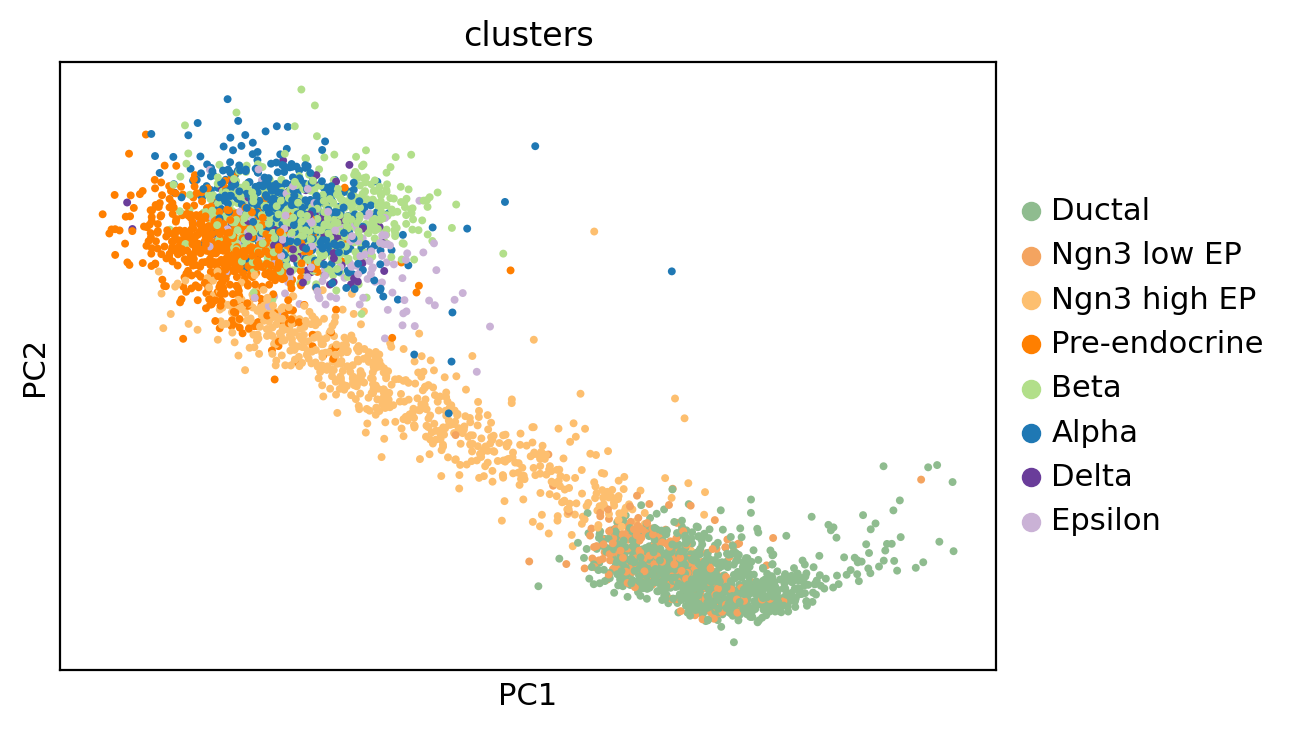

In [55]:
sc.pl.pca(adata,color='clusters')

In [52]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [60]:
#calculate phate
counts = scprep.transform.sqrt(adata2.X)
phate_operator = phate.PHATE(n_jobs=-2)

Y_phate = phate_operator.fit_transform(counts)

Calculating PHATE...
  Running PHATE on 3696 observations and 27998 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.85 seconds.
    Calculating affinities...
    Calculated affinities in 0.15 seconds.
  Calculated graph and diffusion operator in 9.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.35 seconds.
    Calculating KMeans...
    Calculated KMeans in 29.89 seconds.
  Calculated landmark operator in 32.30 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 5.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.47 seconds.
Calculated PHATE in 53.98 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

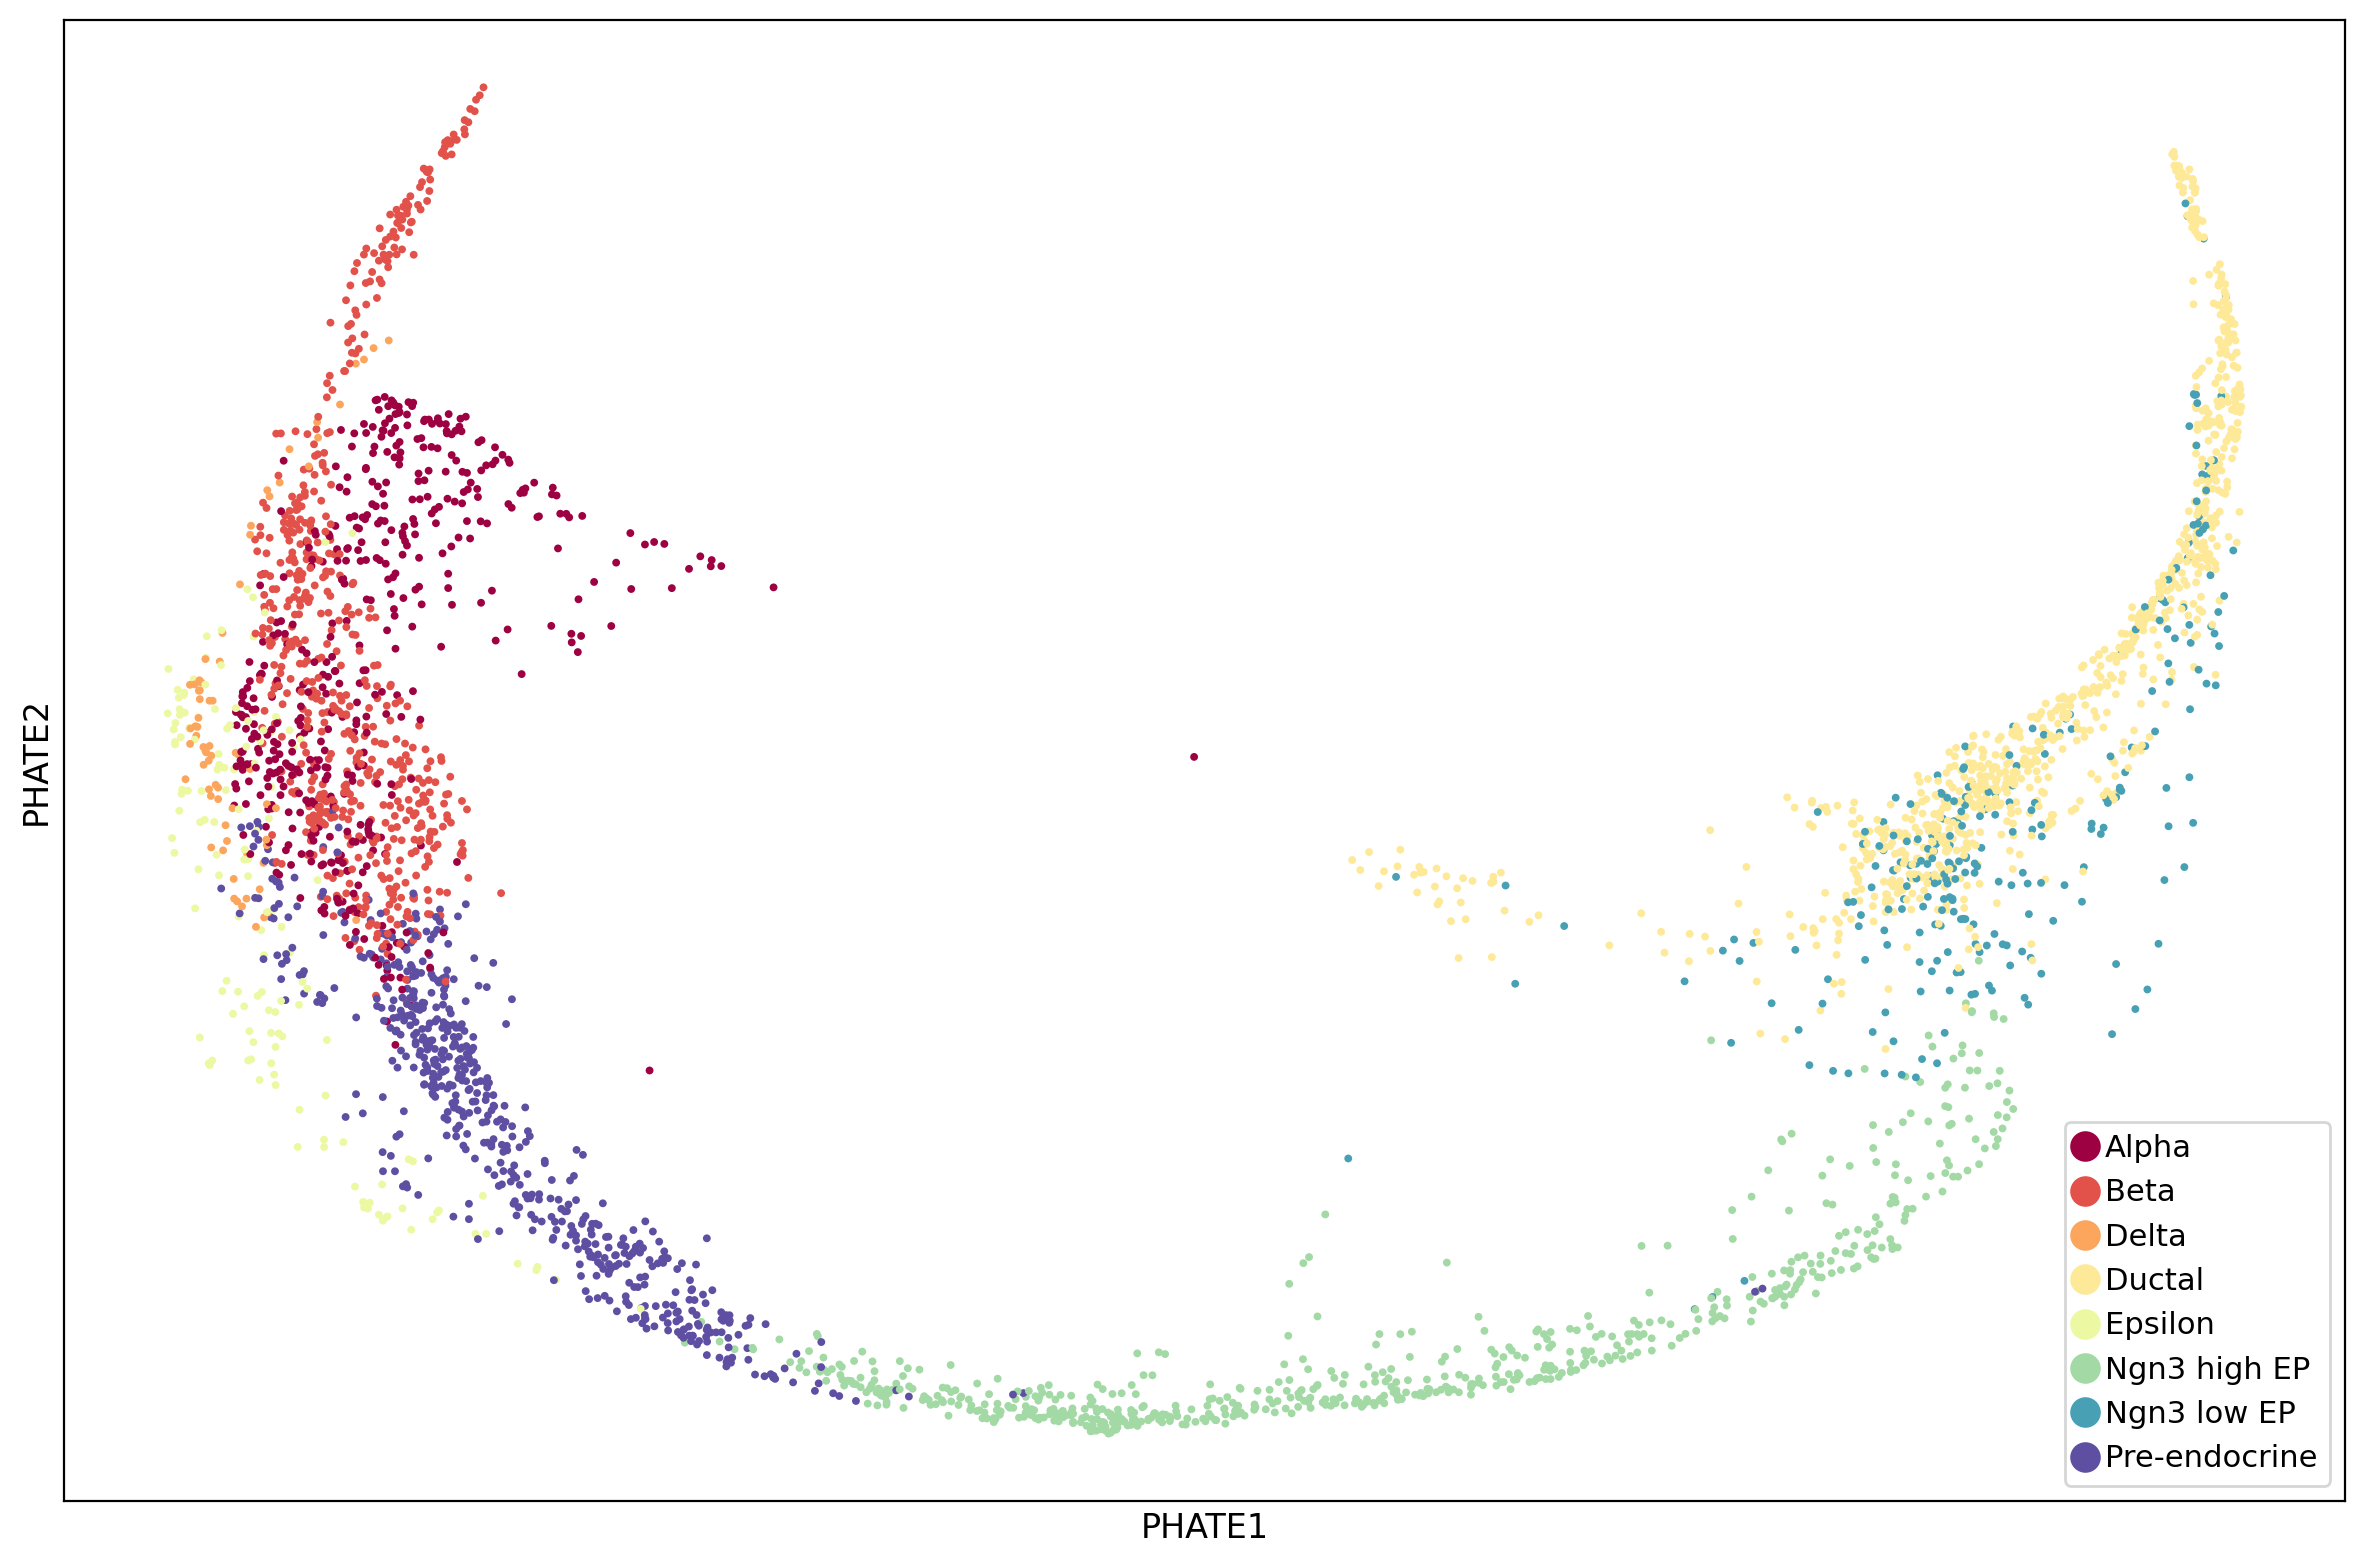

In [62]:
scprep.plot.scatter2d(Y_phate, c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

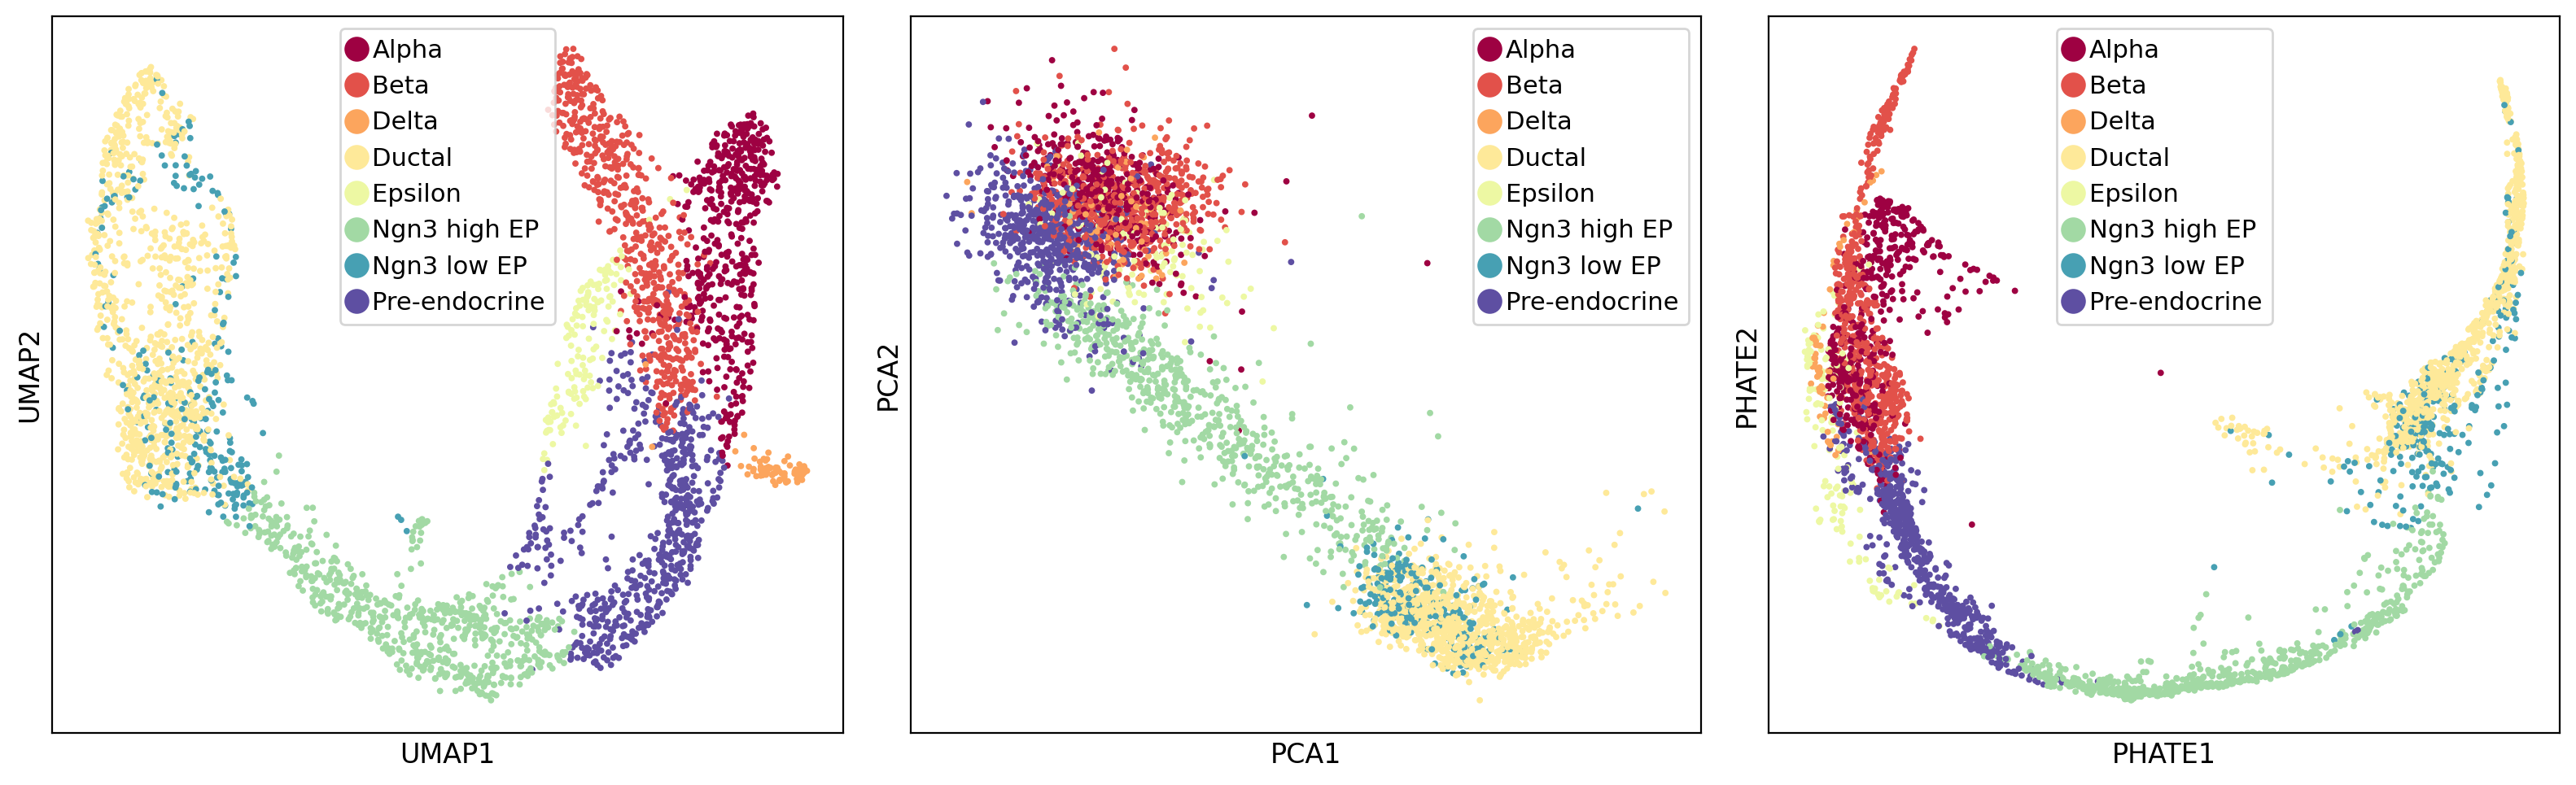

In [296]:
# plot all three
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))


scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax1)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax2)
scprep.plot.scatter2d(Y_phate, c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", ax=ax3)

plt.tight_layout()
plt.show()

Visualize cell scores over each embedding.
-PCA
-UMAP
-PHATE

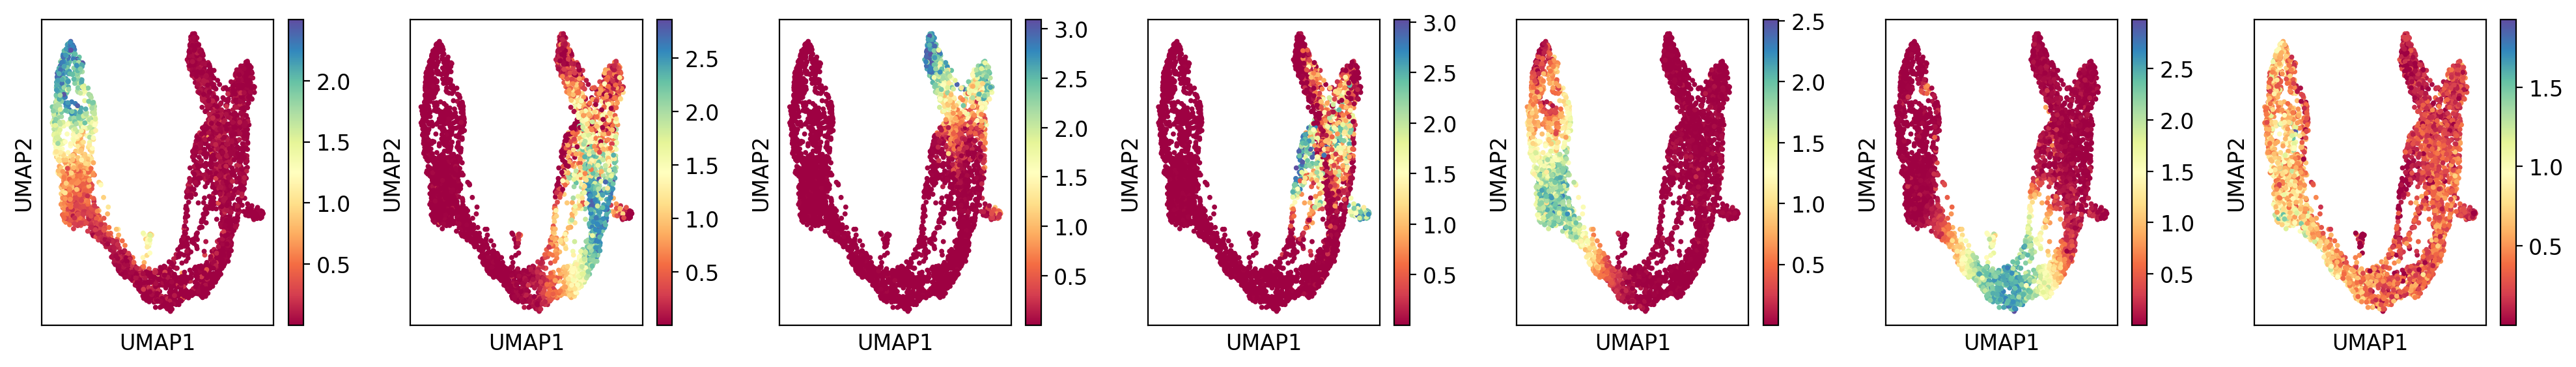

In [297]:
# plot all all 7 scHPF factors on UMAP
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(20, 3))


scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f1'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax1)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f2'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax2)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f3'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax3)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f4'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax4)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f5'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax5)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f6'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax6)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f7'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax7)
plt.tight_layout()
plt.show()

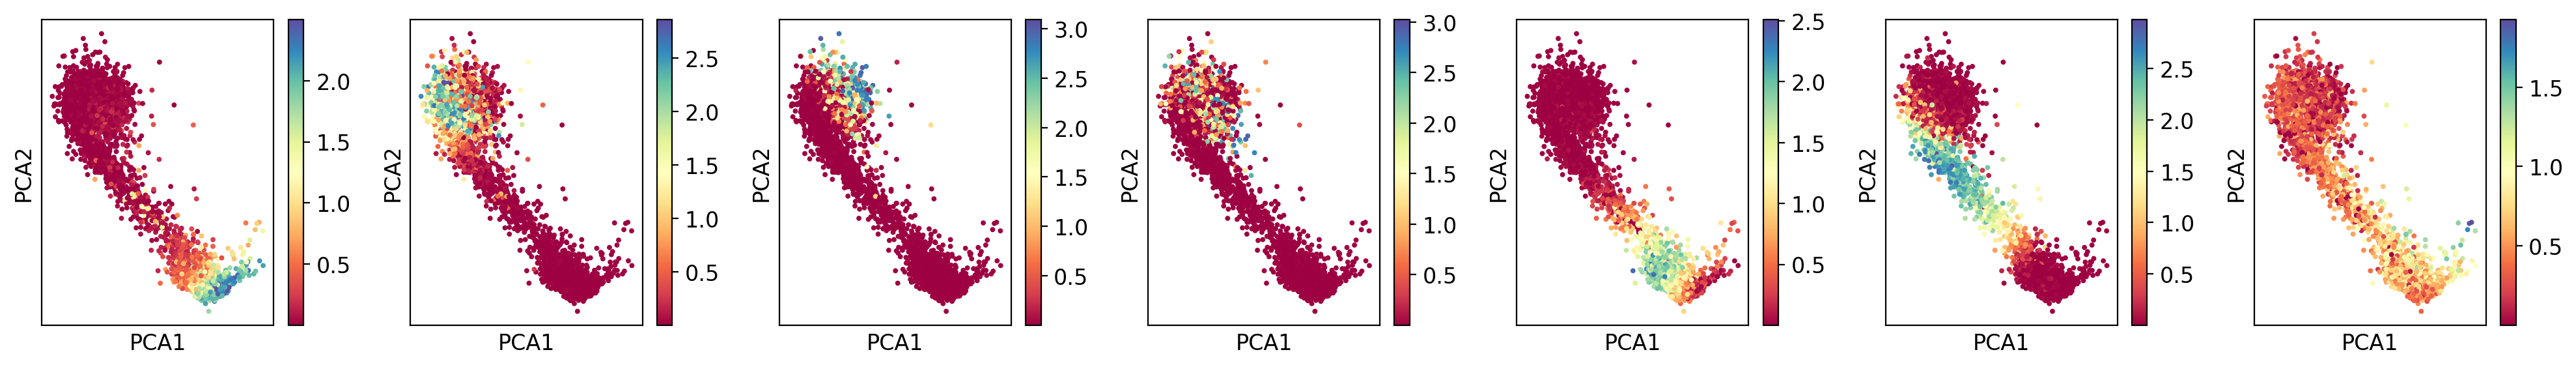

In [75]:
# plot all all 7 scHPF factors on PCA
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(20, 3))


scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f1'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax1)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f2'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax2)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f3'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax3)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f4'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax4)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f5'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax5)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f6'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax6)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['f7'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax7)

plt.tight_layout()
plt.show()

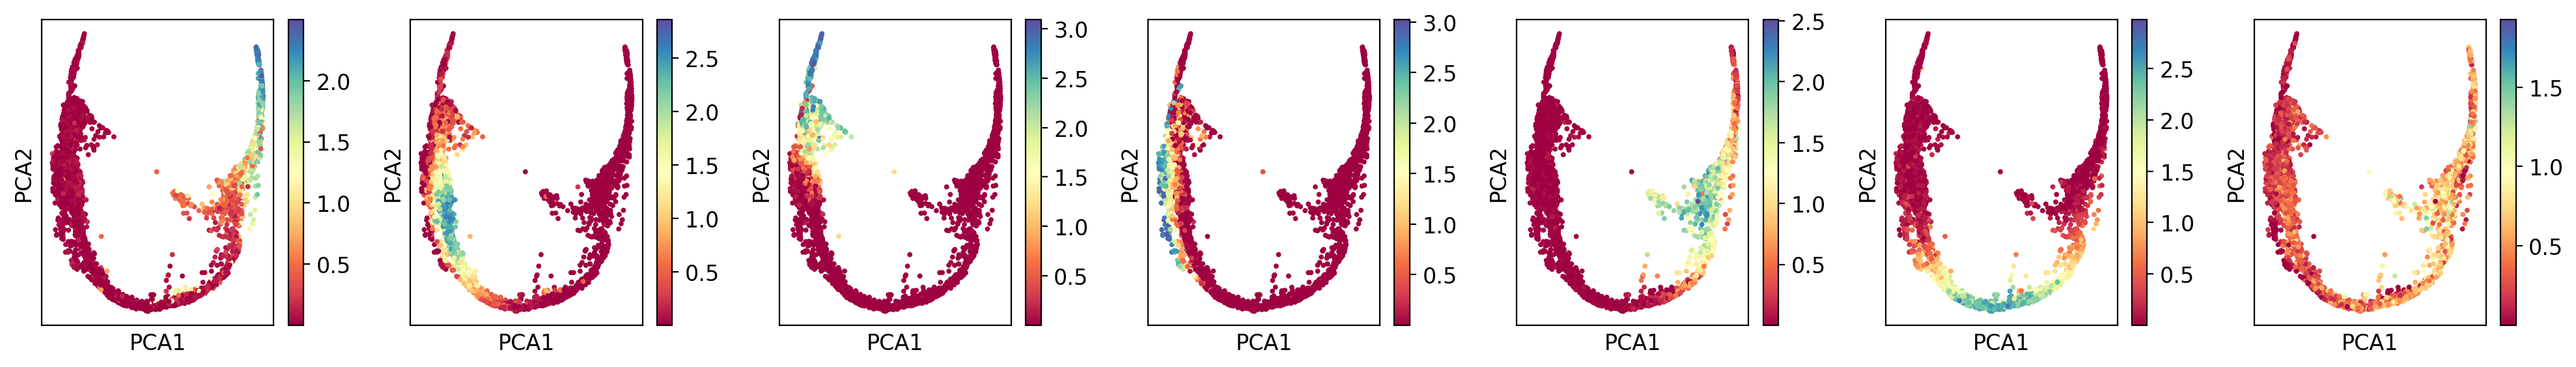

In [76]:
# plot all all 7 scHPF factors on PHATE
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(20, 3))


scprep.plot.scatter2d(Y_phate,c=adata.obs['f1'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax1)
scprep.plot.scatter2d(Y_phate,c=adata.obs['f2'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax2)
scprep.plot.scatter2d(Y_phate,c=adata.obs['f3'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax3)
scprep.plot.scatter2d(Y_phate,c=adata.obs['f4'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax4)
scprep.plot.scatter2d(Y_phate,c=adata.obs['f5'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax5)
scprep.plot.scatter2d(Y_phate,c=adata.obs['f6'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax6)
scprep.plot.scatter2d(Y_phate,c=adata.obs['f7'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax7)

plt.tight_layout()
plt.show()

### Collect Top Genes per Cluster
    - make list of top 20 genes per cluster
    - make heatmap of this list over each factor
    
Recall: These are the objects we have from scHPF

gscores = np.loadtxt(gene_scores) // Genes x Factors numerical scores

cscores = np.loadtxt(cell_scores)  // Cells x Factors numerical scores

rgenes = np.loadtxt(ranked_genes,dtype=str) // Genes x Factors ranked list of genes by contribution

genelist = np.loadtxt(genesfile,dtype=str)  // Genes x 2 mapping of gene names x gene names


In [106]:
#use this list later for an interpretable heat map
j = rgenes.shape[1]
top20 = np.empty(shape=(20*j,1),dtype=object)
for i in range(0,j):
    top20[0+i*20:20+i*20,0]=rgenes[:20,i]
top20.shape

(140, 1)

In [118]:
gscore_df = pd.DataFrame(gscores,index=genelist[:,0],columns = newcols)

Plot a big heatmap with unordered genes. Factors are sparse, as expected! But this is not remotely interpretable

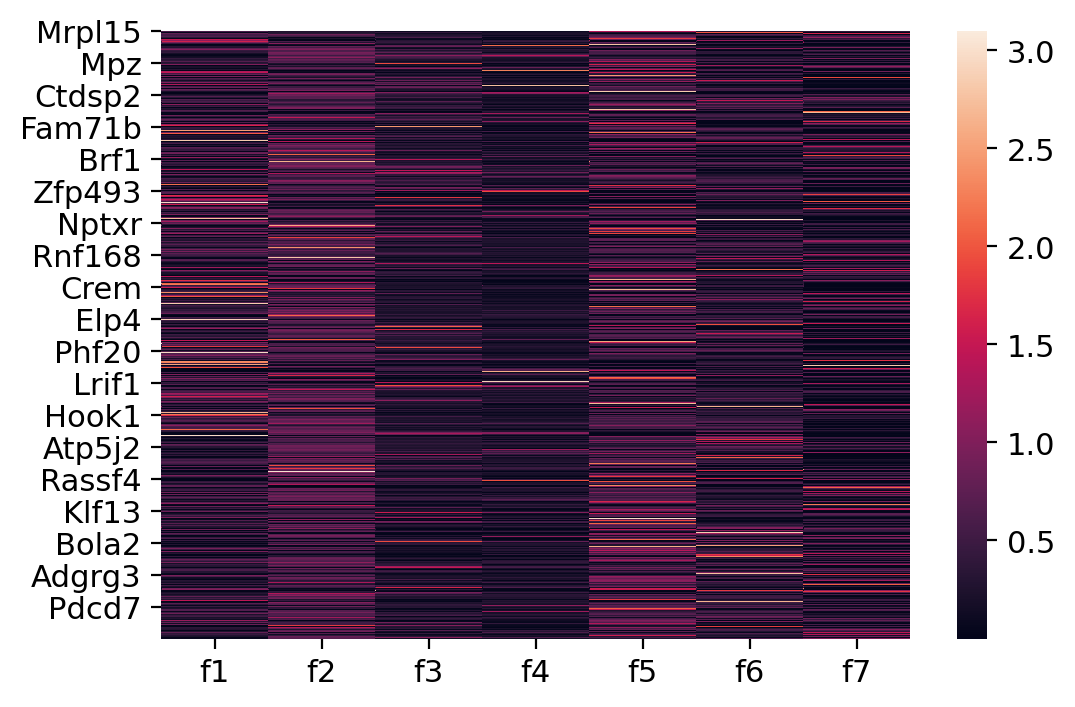

In [120]:
ax = sns.heatmap(gscore_df)
plt.show()

In [127]:
top20_scores = np.empty(shape=(140,7))

for i in range(140):
    top20_scores[i,:]=gscore_df.loc[(top20[i,0]),:]
    
top20_df=pd.DataFrame(top20_scores,index=top20,columns=newcols)

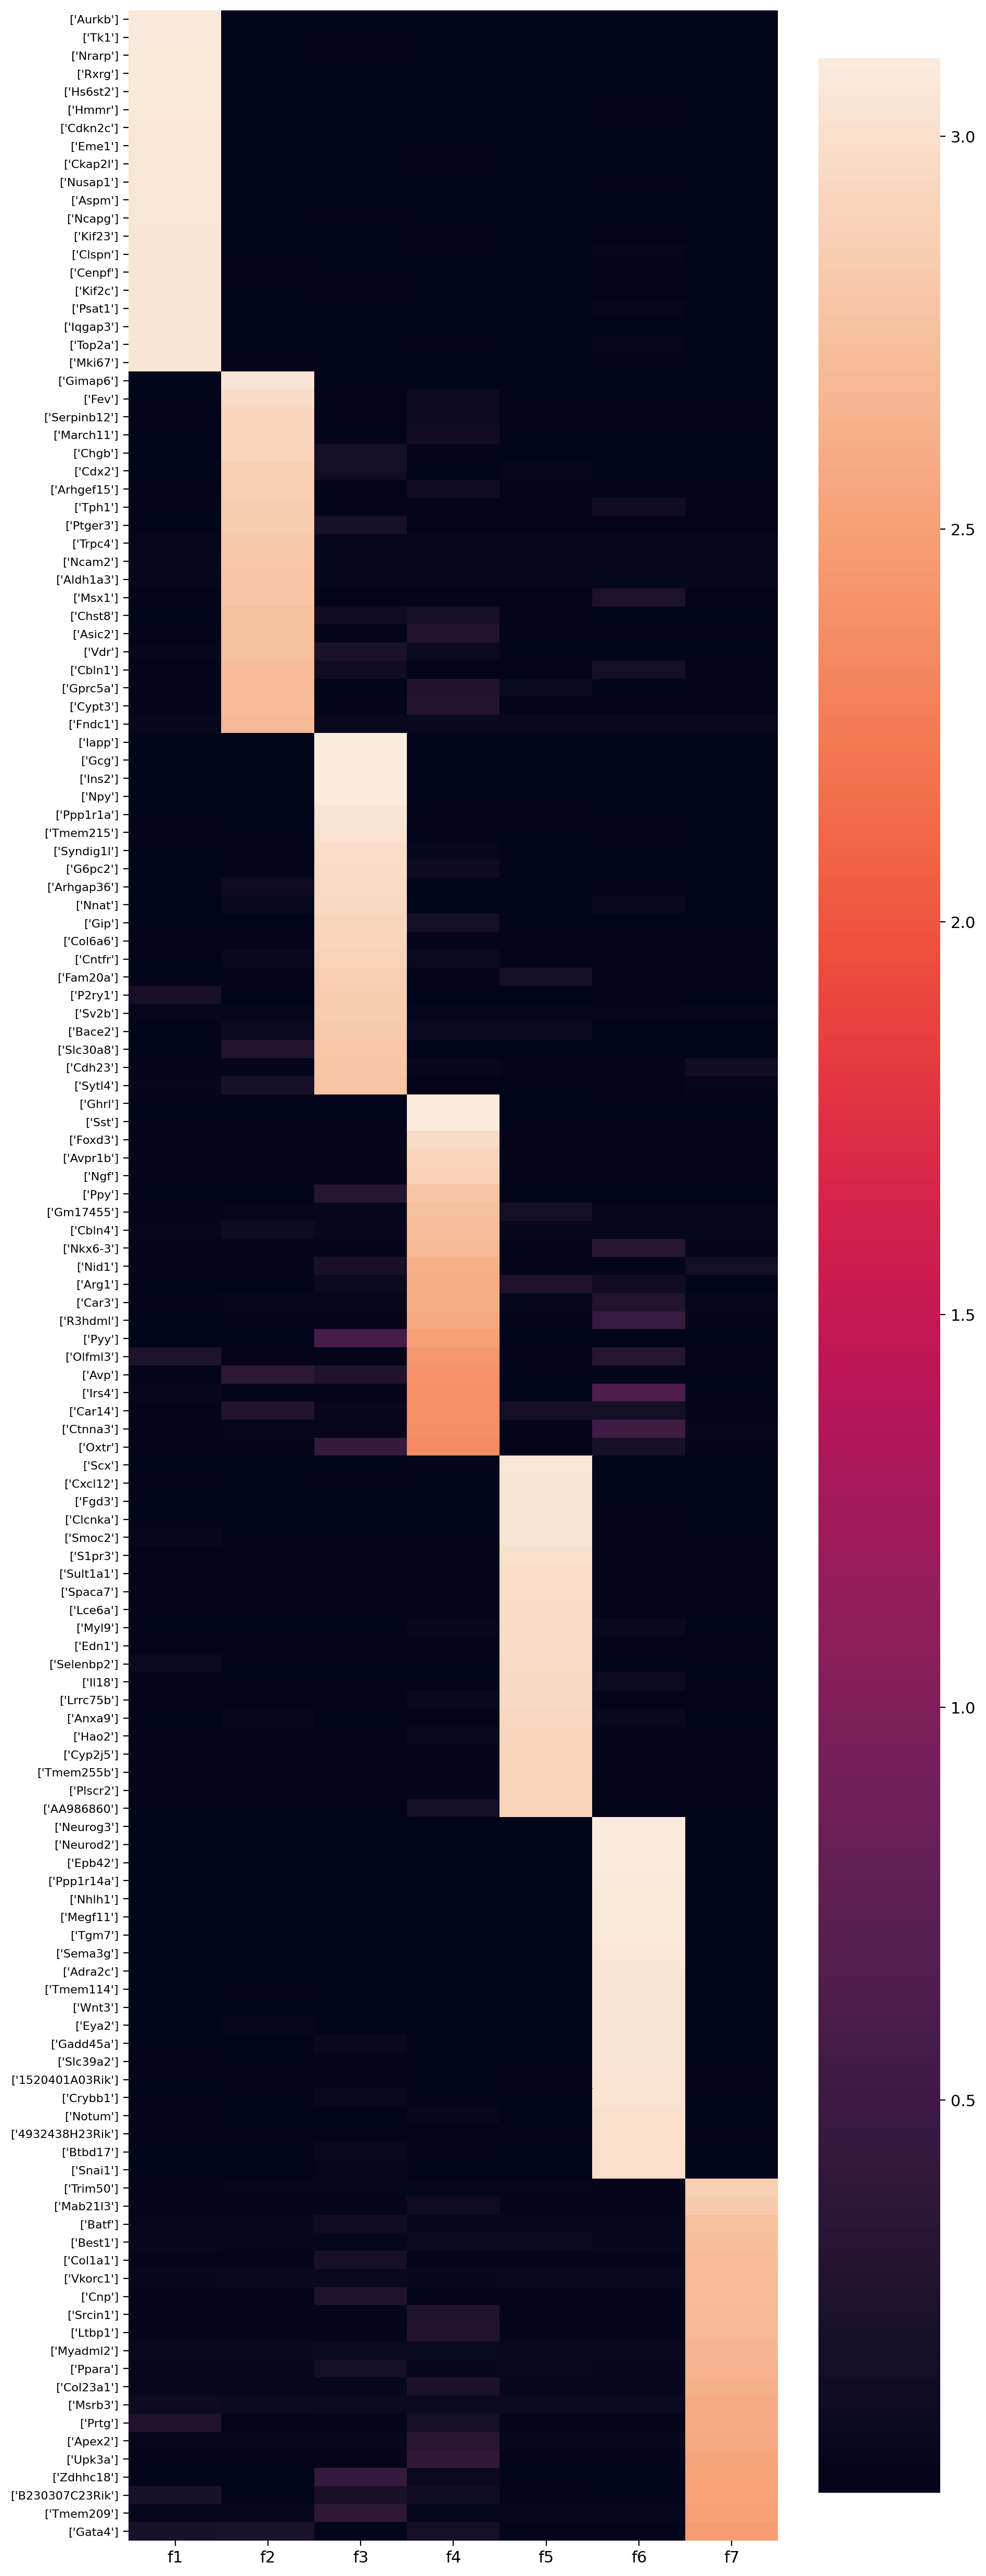

In [143]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 32))

ax1.tick_params(axis='y',which="major",labelsize=8)
ax1 = sns.heatmap(top20_df,yticklabels=top20)
#plt.ylabel(top20,fontsize=3)
plt.show()

### Examine associations between factors and specific biological processes/cell types

Using the Gene Ontology resource, input a list of the top factor genes.

In [156]:
tlist = top20[0:20].tolist()

In [171]:
top20_2 = []
sepe=""
for i in top20:
    top20_2.append(sepe.join(i[0]))

In [179]:
# FACTOR 1
for i in top20_2[0:20]:
    print(i.upper())

AURKB
TK1
NRARP
RXRG
HS6ST2
HMMR
CDKN2C
EME1
CKAP2L
NUSAP1
ASPM
NCAPG
KIF23
CLSPN
CENPF
KIF2C
PSAT1
IQGAP3
TOP2A
MKI67


When put into the Gene Ontology Enrichment tool, at least 13/20 of these genes are strongly associated with cellular division

In [180]:
# FACTOR 2
for i in top20_2[20:40]:
    print(i.upper())

GIMAP6
FEV
SERPINB12
MARCH11
CHGB
CDX2
ARHGEF15
TPH1
PTGER3
TRPC4
NCAM2
ALDH1A3
MSX1
CHST8
ASIC2
VDR
CBLN1
GPRC5A
CYPT3
FNDC1


When put into the Gene Ontology Enrichment tool, no statistically significant results are found for the entire set, but the genes within the set are strongly associated with central nervous system (CNS) development 

Top 5: Speficially associated with serotonin biosynthesis

In [181]:
# FACTOR 3
for i in top20_2[40:60]:
    print(i.upper())

IAPP
GCG
INS2
NPY
PPP1R1A
TMEM215
SYNDIG1L
G6PC2
ARHGAP36
NNAT
GIP
COL6A6
CNTFR
FAM20A
P2RY1
SV2B
BACE2
SLC30A8
CDH23
SYTL4


When put into the Gene Ontology Enrichment tool, these genes are significantly associated with insulin secretion and cellular transport

Top 5: Glycogen catabolism and regulation of metabolism

In [182]:
# FACTOR 4
for i in top20_2[60:80]:
    print(i.upper())

GHRL
SST
FOXD3
AVPR1B
NGF
PPY
GM17455
CBLN4
NKX6-3
NID1
ARG1
CAR3
R3HDML
PYY
OLFML3
AVP
IRS4
CAR14
CTNNA3
OXTR


When put into the Gene Ontology Enrichment tool, these genes are significantly associated with regulation of arterial blood pressure and vasopressin

Top 5:
Regulation of small intestinal transit and bone development

In [183]:
# FACTOR 5
for i in top20_2[80:100]:
    print(i.upper())

SCX
CXCL12
FGD3
CLCNKA
SMOC2
S1PR3
SULT1A1
SPACA7
LCE6A
MYL9
EDN1
SELENBP2
IL18
LRRC75B
ANXA9
HAO2
CYP2J5
TMEM255B
PLSCR2
AA986860


When put into the Gene Ontology Enrichment tool, there are no significant p value hits for the whole set, but  multiple of these genes are closely associated with vasoconstriction, chemotaxis, and cellular response to feeding, which all fits along the same lines of the pancreas and vascular response to insulin.

Top 5: Regulation of leukocyte (immune cells such as macrophage) adhesion and development?

In [185]:
# FACTOR 6
for i in top20_2[100:120]:
    print(i.upper())

NEUROG3
NEUROD2
EPB42
PPP1R14A
NHLH1
MEGF11
TGM7
SEMA3G
ADRA2C
TMEM114
WNT3
EYA2
GADD45A
SLC39A2
1520401A03RIK
CRYBB1
NOTUM
4932438H23RIK
BTBD17
SNAI1


When put into the Gene Ontology Enrichment tool, there are no significant p value hits for the whole set, but multiple of these genes are closely associated with highly specific regional organismic development (think HOX genes)

Top 5: Biological regulation, specifically, synapse maturation 

In [186]:
# FACTOR 7
for i in top20_2[120:140]:
    print(i.upper())

TRIM50
MAB21L3
BATF
BEST1
COL1A1
VKORC1
CNP
SRCIN1
LTBP1
MYADML2
PPARA
COL23A1
MSRB3
PRTG
APEX2
UPK3A
ZDHHC18
B230307C23RIK
TMEM209
GATA4


When put into the Gene Ontology Enrichment tool, there are no significant p value hits for the whole set, but multiple of these genes are closely associated with lung development, diaphragm development, foregut morphogenesis, axonogenesis.

Top 5: T-Helper 2 cell differentiation, AB-T cell differentiation

### Let's make a heatmap of cells sorted by cell types vs factors

In [223]:
clusters = adata.obs['clusters'].unique()
print(clusters)

['Pre-endocrine', 'Ductal', 'Alpha', 'Ngn3 high EP', 'Delta', 'Beta', 'Ngn3 low EP', 'Epsilon']
Categories (8, object): ['Pre-endocrine', 'Ductal', 'Alpha', 'Ngn3 high EP', 'Delta', 'Beta', 'Ngn3 low EP', 'Epsilon']


In [281]:
clustersmat = pd.DataFrame()
s=0
sizes = []
names = []
for i in range(len(clusters)):
    clustersmat = clustersmat.append(adata.obs.loc[adata.obs['clusters']==clusters[i]])
    names.append(clusters[i])
    sizes.append(adata.obs.loc[adata.obs['clusters']==clusters[i]].shape[0]+s)
    s=s+sizes[len(sizes)-1]


In [282]:
factsmat = clustersmat.iloc[:,-7:]
clustlist = clustersmat.iloc[:,1]

In [283]:
factsmat.index=clustlist
factsmat

f1        f2        f3        f4        f5        f6  \
clusters                                                                    
Pre-endocrine  0.000250  1.950546  0.000342  0.775351  0.000205  0.103975   
Pre-endocrine  0.000300  2.055720  0.138322  0.498845  0.030161  0.195192   
Pre-endocrine  0.000317  2.430759  0.000423  0.000590  0.000258  0.190037   
Pre-endocrine  0.002340  2.401743  0.024973  0.266410  0.012598  0.052875   
Pre-endocrine  0.000296  1.778363  0.005747  0.000556  0.000243  1.122555   
...                 ...       ...       ...       ...       ...       ...   
Epsilon        0.000110  0.000090  0.003045  2.999280  0.001303  0.095431   
Epsilon        0.000095  0.000076  0.010448  2.945799  0.004604  0.046931   
Epsilon        0.006774  0.000104  0.124540  2.630362  0.008411  0.083546   
Epsilon        0.002713  0.000077  0.294248  2.734722  0.010319  0.000097   
Epsilon        0.058225  0.877006  0.062057  1.989054  0.029329  0.083306   

                     f7  
clusters                 
Pre-endocrine  0.267835  
Pre-endocrine  0.179683  
Pre-endocrine  0.475730  
Pre-endocrine  0.337344  
Pre-endocrine  0.190461  
...                 ...  
Epsilon        0.000091  
Epsilon        0.091478  
Epsilon        0.245513  
Epsilon        0.057244  
Epsilon        0.000124  

[3696 rows x 7 columns]

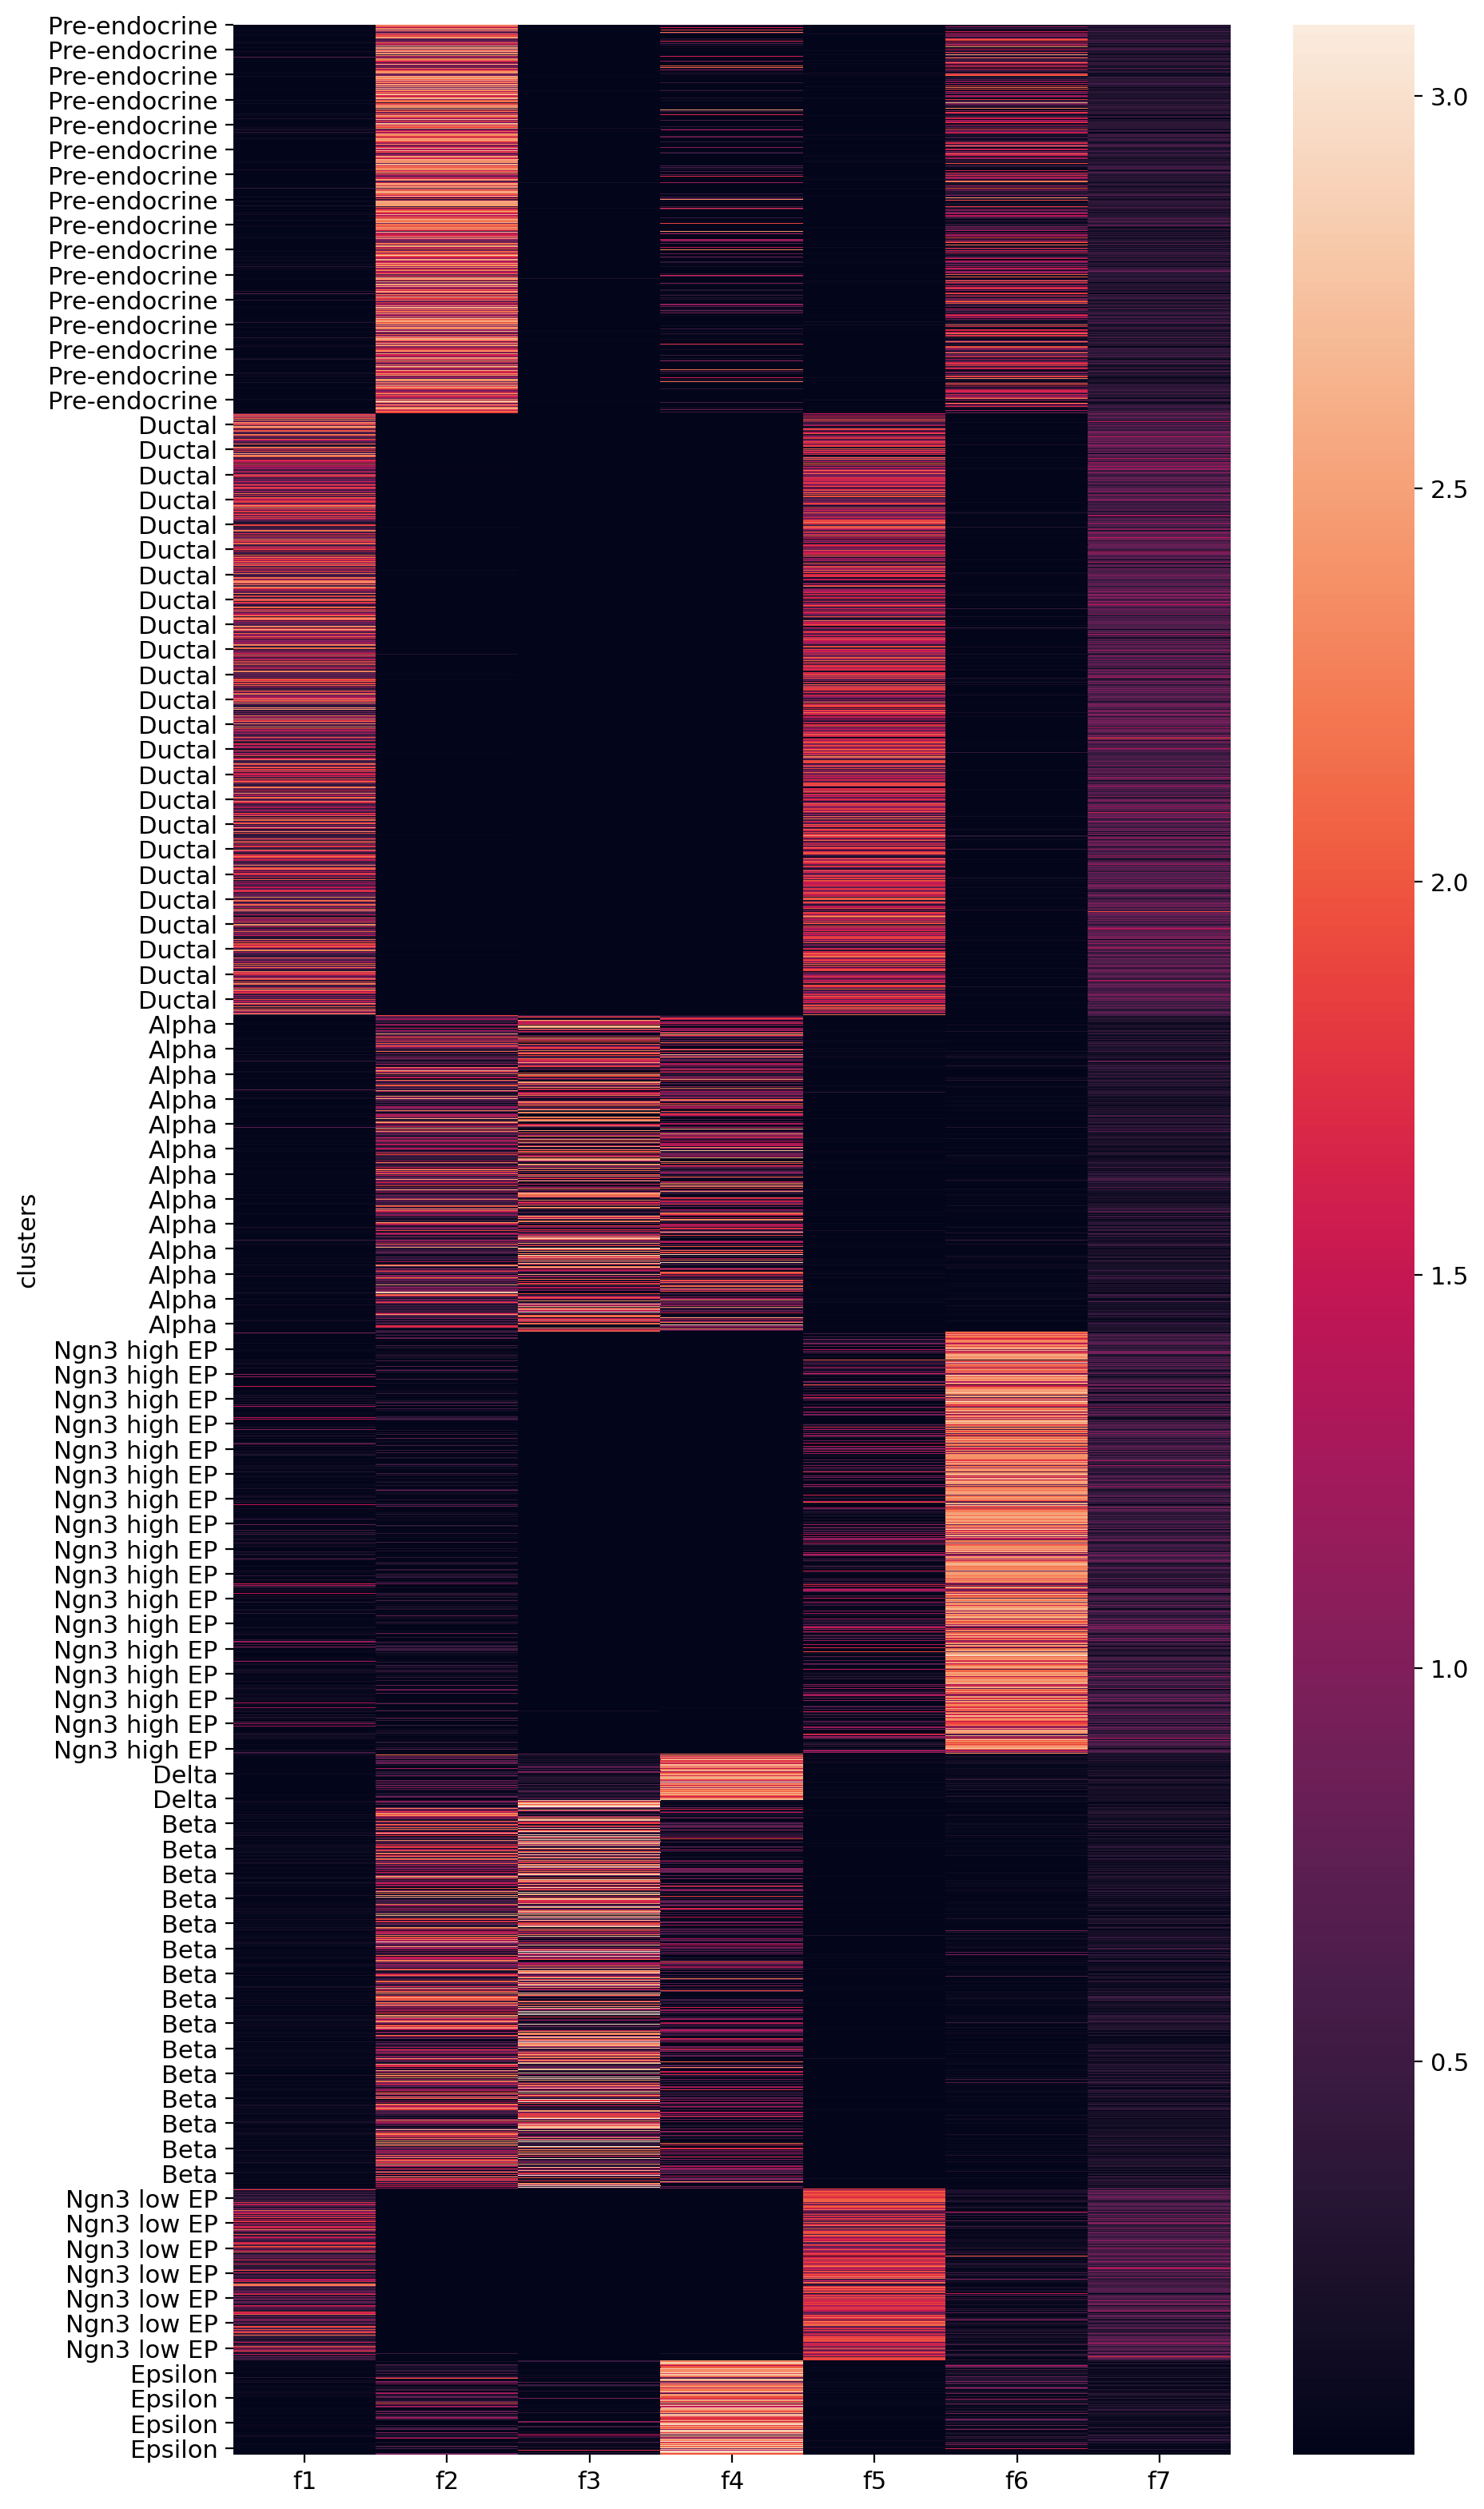

In [291]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 20))
#ax1.get_yticks(sizes)
#ax1.yticks(sizes)
#ax1.tick_params(axis='y',which="major",labelsize=8)
ax = sns.heatmap(factsmat)
plt.show()

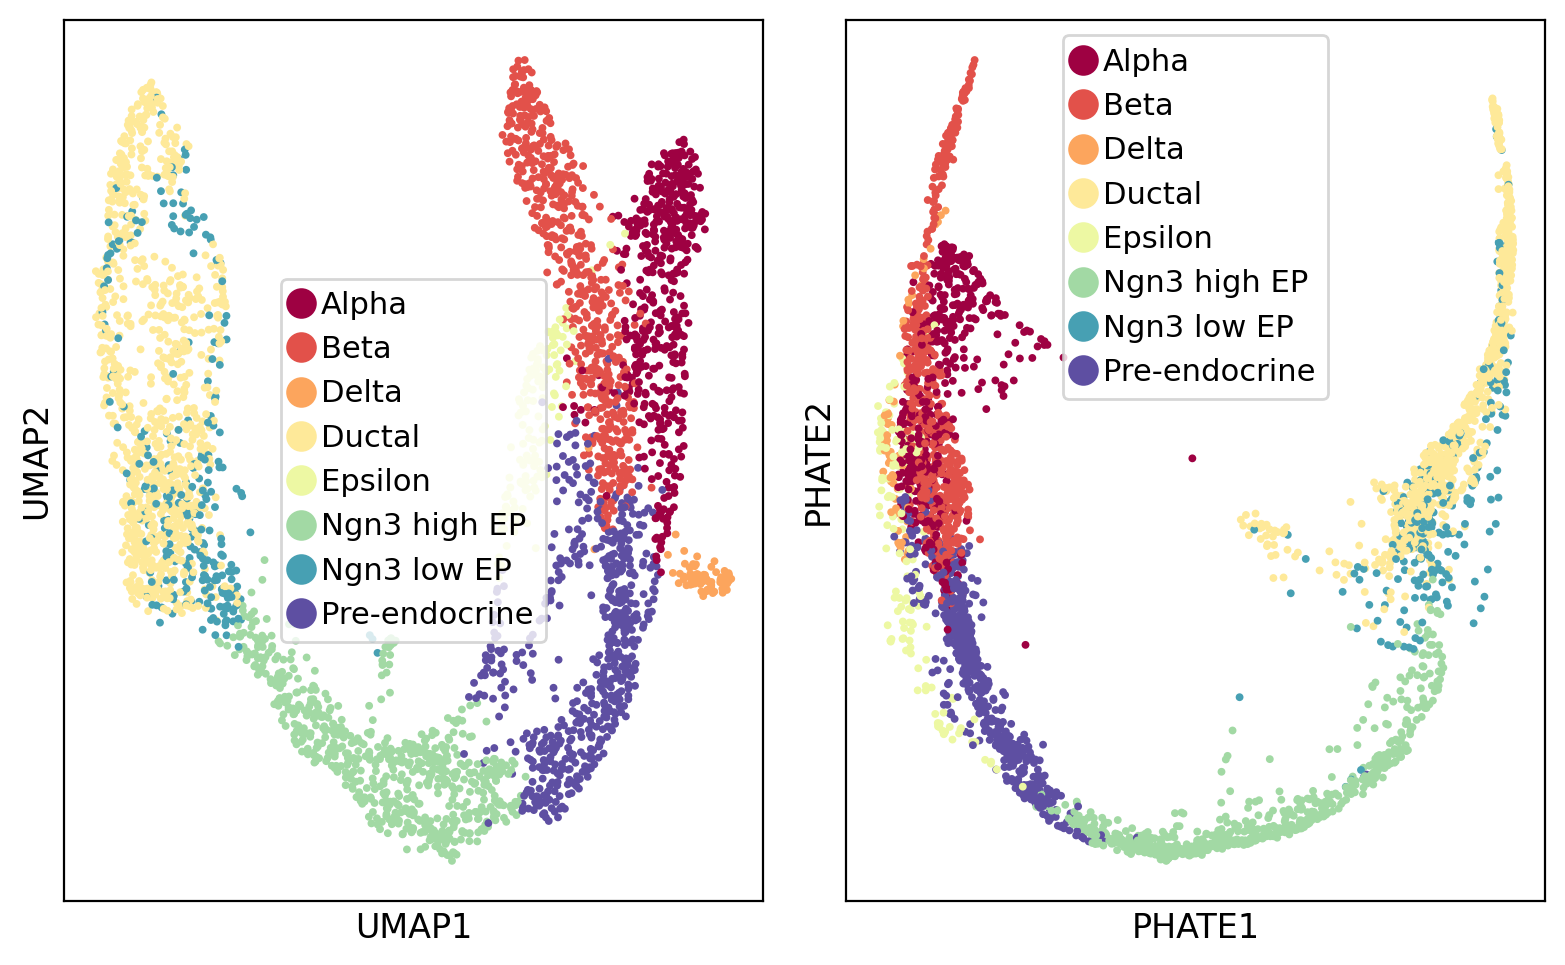

In [302]:
# plot all three embeddings
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 5))


scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax1)

scprep.plot.scatter2d(Y_phate, c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", ax=ax2)

plt.tight_layout()
plt.show()

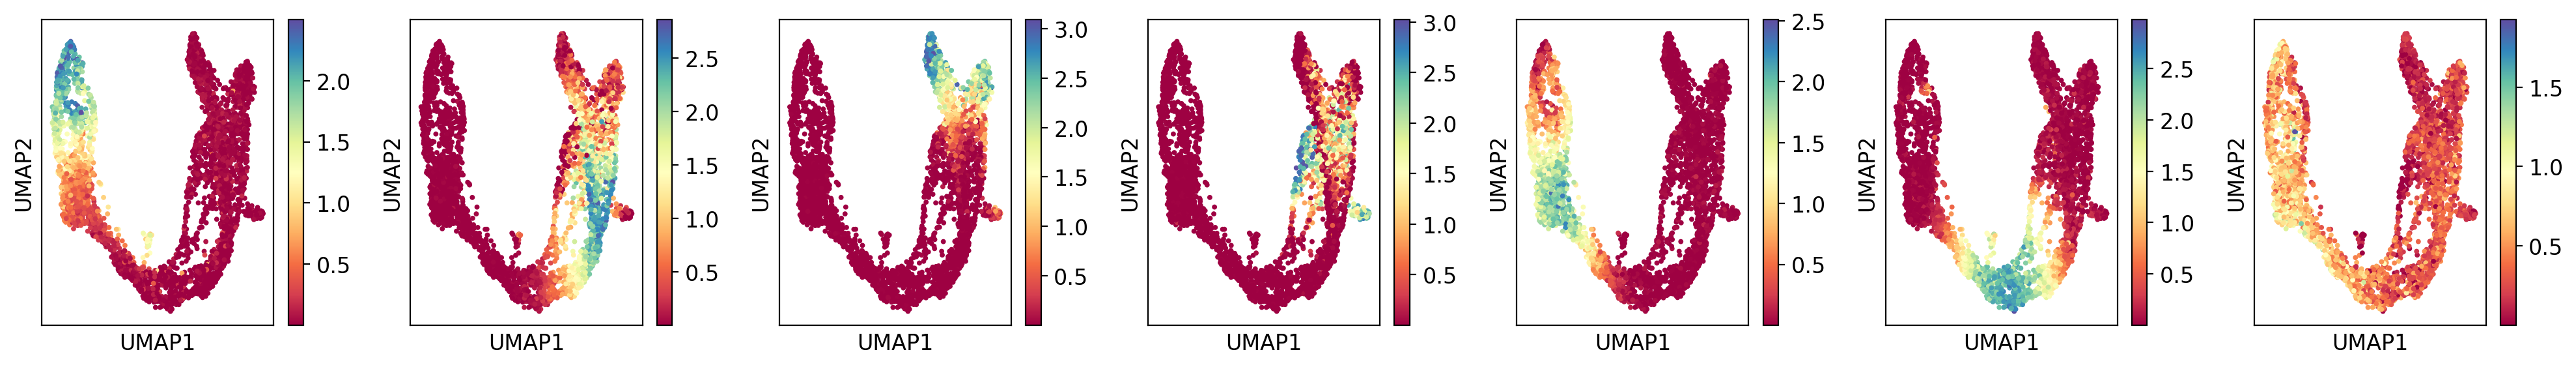

In [299]:
# plot all all 7 scHPF factors on UMAP
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(20, 3))


scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f1'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax1)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f2'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax2)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f3'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax3)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f4'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax4)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f5'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax5)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f6'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax6)
scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['f7'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax7)
plt.tight_layout()
plt.show()

###  These expression programs do actually give insight into the biology. 

#### Example:

Factor 1 is expressed in a gradient across the region of ductal and Ngn3 low EP cells. The higher portion of this gradient, where there is more expression of this associated factor, is therefore the portion of cells that is most actively engaged in mitosis.

Factor 3 is most expressed as a gradient across alpha and beta cells, skewing toward the 'tails' of the two distributions. These genes are highly involved in processing of glycogen and metabolic regulation, which is a known function of pancreatic alpha and beta cells. The overall manifold seems to be a pathway starting on one end with naive/stem differentiating cells and functional pancreatic regulatory cells, such that it makes sense for the regulatory cells to be the opposing "tail", and for the differentiated functions of these mature cells to tend towards the ends of these tails.

### RNA Velocity

#### I did not get to the RNA velocity portion of this analysis, but am eager to do so! 

RNA Velocity breaks the overall matrix into a spliced/unspliced matrix, where it can be assumed that these are generated from two seperate near time points. By dynamical modeling, this then allows us to create a matrix of the direction cells are moving in transcriptional space, with a cells x genes matrix where positive values are upregulated genes and negative values are downregulated genes. Since scHPF is sufficient to resolve changes along a time axis in this dataset, I expect there might be a considerable consistency in expressed gene sets for clusters within RNA velocity and the gene sets/factors from scHPF. This would be cool to show graphically with RNA velocity vectors as well. 